#### Import requiring libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch,torchvision,torchmetrics
from tqdm import tqdm

#### Loading and preprocessing the dataset

In [3]:
batch_size=60
#Initialize the number of samples used
#for both training and testing

train_dataset = torchvision.datasets.MNIST(root="dataset/",download=True,train=True,transform=torchvision.transforms.ToTensor())
#we convert the data into tensors via
# .ToTensor()

train_loader = torch.utils.data.DataLoader(dataset=train_dataset,batch_size=batch_size,shuffle=True)
# `DataLoader` creates an iterable over
#the training set

# `shuffle` will randomize the data
#at each epoch, which will help
#improving the model

test_dataset = torchvision.datasets.MNIST(root="dataset/",download=True,train=False,transform=torchvision.transforms.ToTensor())
test_loader = torch.utils.data.DataLoader(dataset=test_dataset,batch_size=batch_size,shuffle=True)


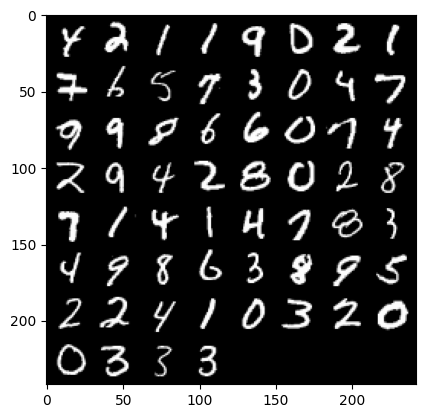

In [4]:
def show_image(image):
    np_image = image.numpy()
    plt.imshow(np.transpose(np_image,(1,2,0)))
    plt.show()
# image.numy() will convert the tensor into a numpy array
# np.transpose(np_image,(1,2,0)) will rearrange the pic
#format, so it will be compatible with matplotlib,
#which requires : (height,width,channels) --> (1,2,0)

data_iter = iter(train_loader)
images,labels = next(data_iter)

show_image(torchvision.utils.make_grid(images))




### Defining the CNN architecture

In [5]:
class CNN(torch.nn.Module):
    def __init__(self,in_channels,nbr_classes):
        super(CNN,self).__init__()

        # 1st 2D convolutional layer with 8 filters/different features
        self.conv1 = torch.nn.Conv2d(in_channels=in_channels,out_channels=8,kernel_size=3,padding=1)
        
        # Max pooling layer
        self.pool = torch.nn.MaxPool2d(kernel_size=2,stride=2)

        # 2nd 2D convolutional layer
        self.conv2 = torch.nn.Conv2d(in_channels=8,out_channels=16,kernel_size=3,padding=1)

        # Fully connected layer
        self.fc1 = torch.nn.Linear(16*7*7,nbr_classes)
    def forward(self,x):
        # Apply first convolution and ReLU
        x = torch.nn.functional.relu(self.conv1(x))

        # Apply Max Pooling
        x = self.pool(x)

        # Apply second convolution and ReLU
        x = torch.nn.functional.relu(self.conv2(x))

        # Apply second Max Pooling
        x = self.pool(x)

        # Flatten (Reshape) the tensors from 2D to 1D
        x = x.reshape(x.shape[0],-1)

        # Apply fully connected layer
        x = self.fc1(x)
        return x


device = "cuda" if torch.cuda.is_available() else "cpu"
model = CNN(in_channels=1,nbr_classes=10).to(device)
print(model)



CNN(
  (conv1): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=784, out_features=10, bias=True)
)


### Training the CNN model

In [6]:
# Define loss function
loss_fn = torch.nn.CrossEntropyLoss()

# Define optimizer function
optimizer = torch.optim.Adam(model.parameters(),lr=0.001)

In [7]:
epochs = 10
for epoch in range(epochs):
    print(f"Epoch [{epoch+1}/{epochs}]")

    for batch_index, (data,targets) in enumerate(tqdm(train_loader)):
        data = data.to(device)
        targets = targets.to(device)
        scores = model(data)
        loss = loss_fn(scores,targets)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()


Epoch [1/10]


100%|██████████| 1000/1000 [00:10<00:00, 92.85it/s]


Epoch [2/10]


100%|██████████| 1000/1000 [00:11<00:00, 90.86it/s]


Epoch [3/10]


100%|██████████| 1000/1000 [00:10<00:00, 91.01it/s]


Epoch [4/10]


100%|██████████| 1000/1000 [00:10<00:00, 93.51it/s]


Epoch [5/10]


100%|██████████| 1000/1000 [00:10<00:00, 93.15it/s]


Epoch [6/10]


100%|██████████| 1000/1000 [00:10<00:00, 92.57it/s]


Epoch [7/10]


100%|██████████| 1000/1000 [00:12<00:00, 77.41it/s]


Epoch [8/10]


100%|██████████| 1000/1000 [00:12<00:00, 81.22it/s]


Epoch [9/10]


100%|██████████| 1000/1000 [00:15<00:00, 63.96it/s]


Epoch [10/10]


100%|██████████| 1000/1000 [00:13<00:00, 74.28it/s]


#### Evaluate the model 

In [ ]:
acc = torchmetrics.Accuracy(task="multiclass",num_classes=10)
precision = torchmetrics.Precision(task="multiclass",num_classes=10)
recall = torchmetrics.Recall(task="multiclass",num_classes=10)
model.eval()

with torch.no_grad():
    for images, labels in test_loader:
        output=model(images)
        _,preds=torch.max(output,1)
        #Unpack the torch.max in order to obtain tensors, not tuples
        acc.update(preds,labels)
        precision.update(preds,labels)
        recall.update(preds,labels)
test_accuracy=acc.compute()

print(f"Test Accuracy: {test_accuracy}")

Test Accuracy: 0.9846000075340271
